# Patient Diabetes Progression Analysis

This notebook analyzes the progression of diabetes risk for patients over multiple visits. It uses the trained model to predict risk levels and track changes in patient condition over time.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model and preprocessing components
model_path = '../models/diabetes_rf_model.pkl'
scaler_path = '../scaler.pkl'
columns_path = '../columns.pkl'

# Load model components
model = joblib.load(model_path)
scaler = joblib.load(scaler_path)
with open(columns_path, 'rb') as f:
    columns = pickle.load(f)

print("Model and preprocessing components loaded successfully!")

Model and preprocessing components loaded successfully!


c:\Users\Hp\Desktop\workspace\projects\diabetes-predictor\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Hp\Desktop\workspace\projects\diabetes-predictor\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
# Load and preprocess patient data
def load_patient_data():
    """Load patient data from CSV and perform initial preprocessing"""
    df = pd.read_csv('../data/patient_data.csv')
    
    # Convert date string to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create dummy variables for categorical columns
    categorical_columns = ['Physical Activity', 'Smoking status', 'Alcohol Intake', 'Diet_Type', 'Family history']
    
    for col in categorical_columns:
        if col in df.columns:
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df.drop(col, axis=1, inplace=True)
    
    # Rename waist ratio column if needed
    if 'Waist ratio' in df.columns:
        df = df.rename(columns={'Waist ratio': 'Waiste ratio'})
    
    return df

def preprocess_features(data):
    """Preprocess features using the same scaler and columns as the training data"""
    # Select only the feature columns used during training
    feature_cols = [col for col in columns if col not in ['Outcome']]
    
    # Create missing columns with 0s
    for col in feature_cols:
        if col not in data.columns:
            data[col] = 0
    
    # Select and order columns to match training data
    X = data[feature_cols].copy()
    
    # Scale the features
    X_scaled = scaler.transform(X)
    
    # Create DataFrame with scaled values and original column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=data.index)
    
    return X_scaled_df

# Load the patient data
patient_data = load_patient_data()
print("Patient data shape:", patient_data.shape)
print("\nSample of patient data:")
print(patient_data.head())
print("\nAvailable columns:")
print(patient_data.columns.tolist())

Patient data shape: (24, 27)

Sample of patient data:
   Patient_ID       Date  Age   BMI  Blood Glucose  Blood Pressure  HbA1c  \
0           1 2023-01-01   45  27.5            105             120    5.8   
1           1 2023-07-01   45  28.2            130             125    6.3   
2           1 2024-01-01   46  29.0            160             130    7.0   
3           1 2024-07-01   46  29.3            170             132    7.2   
4           2 2023-02-15   50  30.1            115             135    6.1   

   Insulin Level  Skin thickness  Pregnancies  ...  Physical Activity_4  \
0             15              20            2  ...                False   
1             20              25            2  ...                False   
2             30              30            2  ...                False   
3             32              31            2  ...                False   
4             25              22            3  ...                False   

   Smoking status_0  Smoking sta

In [5]:
# Function to predict probability and determine risk level
def predict_risk(data):
    """
    Predict diabetes probability and determine risk level for given patient data
    
    Parameters:
    data (pd.DataFrame): Patient data with required features
    
    Returns:
    tuple: (probability, risk_level)
    """
    # Preprocess the features
    X_scaled = preprocess_features(data)
    
    # Get probability predictions
    probabilities = model.predict_proba(X_scaled)[:, 1]
    
    # Determine risk level based on probability
    def get_risk_level(prob):
        if prob < 0.3:
            return "Low"
        elif prob < 0.6:
            return "Medium"
        else:
            return "High"
    
    risk_levels = [get_risk_level(p) for p in probabilities]
    
    return probabilities, risk_levels

# Test the prediction function on a few samples
test_samples = patient_data.head(3)
probs, risks = predict_risk(test_samples)
print("Sample predictions:")
for i, (prob, risk) in enumerate(zip(probs, risks)):
    print(f"Sample {i+1}: Probability = {prob:.3f}, Risk Level = {risk}")

Sample predictions:
Sample 1: Probability = 0.452, Risk Level = Medium
Sample 2: Probability = 0.429, Risk Level = Medium
Sample 3: Probability = 0.444, Risk Level = Medium


C:\Users\Hp\AppData\Local\Temp\ipykernel_8588\1782408397.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = 0
C:\Users\Hp\AppData\Local\Temp\ipykernel_8588\1782408397.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = 0
C:\Users\Hp\AppData\Local\Temp\ipykernel_8588\1782408397.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [6]:
def check_progression(patient_id):
    """
    Analyze progression of diabetes risk for a specific patient
    
    Parameters:
    patient_id (int or str): Patient ID to analyze
    
    Returns:
    pd.DataFrame: DataFrame with progression analysis
    """
    # Get patient's records
    patient_records = patient_data[patient_data['Patient_ID'] == patient_id].copy()
    
    if len(patient_records) == 0:
        print(f"No records found for patient {patient_id}")
        return None
    
    # Sort by date
    patient_records = patient_records.sort_values('Date')
    
    # Get predictions for all visits
    probabilities, risk_levels = predict_risk(patient_records)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Date': patient_records['Date'],
        'Predicted_Probability': probabilities,
        'Risk_Level': risk_levels
    })
    
    # Determine progression
    def determine_progression(current_risk, prev_risk):
        risk_scores = {'Low': 1, 'Medium': 2, 'High': 3}
        if prev_risk is None:
            return 'Initial Visit'
        
        current_score = risk_scores[current_risk]
        prev_score = risk_scores[prev_risk]
        
        if current_score < prev_score:
            return 'Improved'
        elif current_score > prev_score:
            return 'Worsened'
        else:
            return 'Stable'
    
    # Calculate progression
    prev_risk = None
    progression = []
    
    for risk in results['Risk_Level']:
        prog = determine_progression(risk, prev_risk)
        progression.append(prog)
        prev_risk = risk
    
    results['Progression'] = progression
    
    return results

# Get list of unique patient IDs
unique_patients = patient_data['Patient_ID'].unique()
print(f"Available Patient IDs: {unique_patients[:5]}")

# Test the progression function with one patient
test_patient_id = unique_patients[0]
progression_results = check_progression(test_patient_id)
print(f"\nProgression analysis for Patient {test_patient_id}:")
print(progression_results)

Available Patient IDs: [1 2 3 4 5]

Progression analysis for Patient 1:
        Date  Predicted_Probability Risk_Level    Progression
0 2023-01-01               0.451515     Medium  Initial Visit
1 2023-07-01               0.428702     Medium         Stable
2 2024-01-01               0.443906     Medium         Stable
3 2024-07-01               0.434891     Medium         Stable


c:\Users\Hp\Desktop\workspace\projects\diabetes-predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


c:\Users\Hp\Desktop\workspace\projects\diabetes-predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


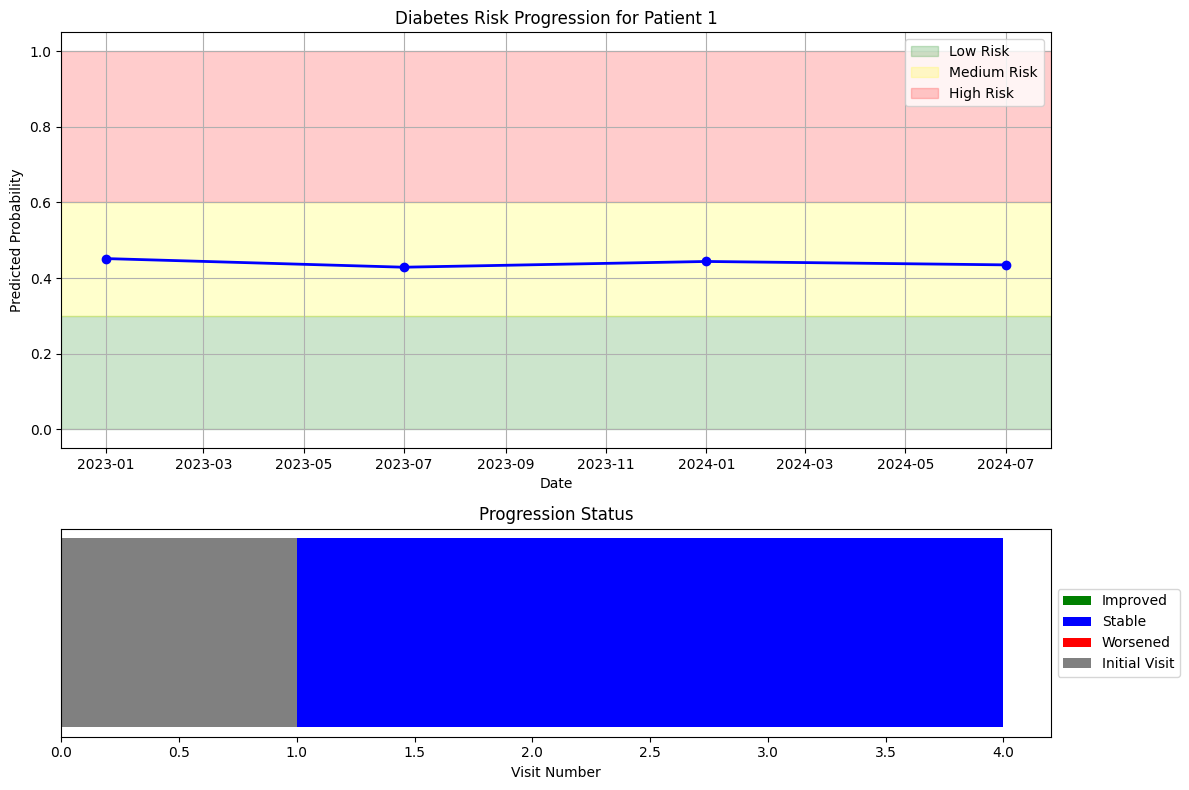

c:\Users\Hp\Desktop\workspace\projects\diabetes-predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


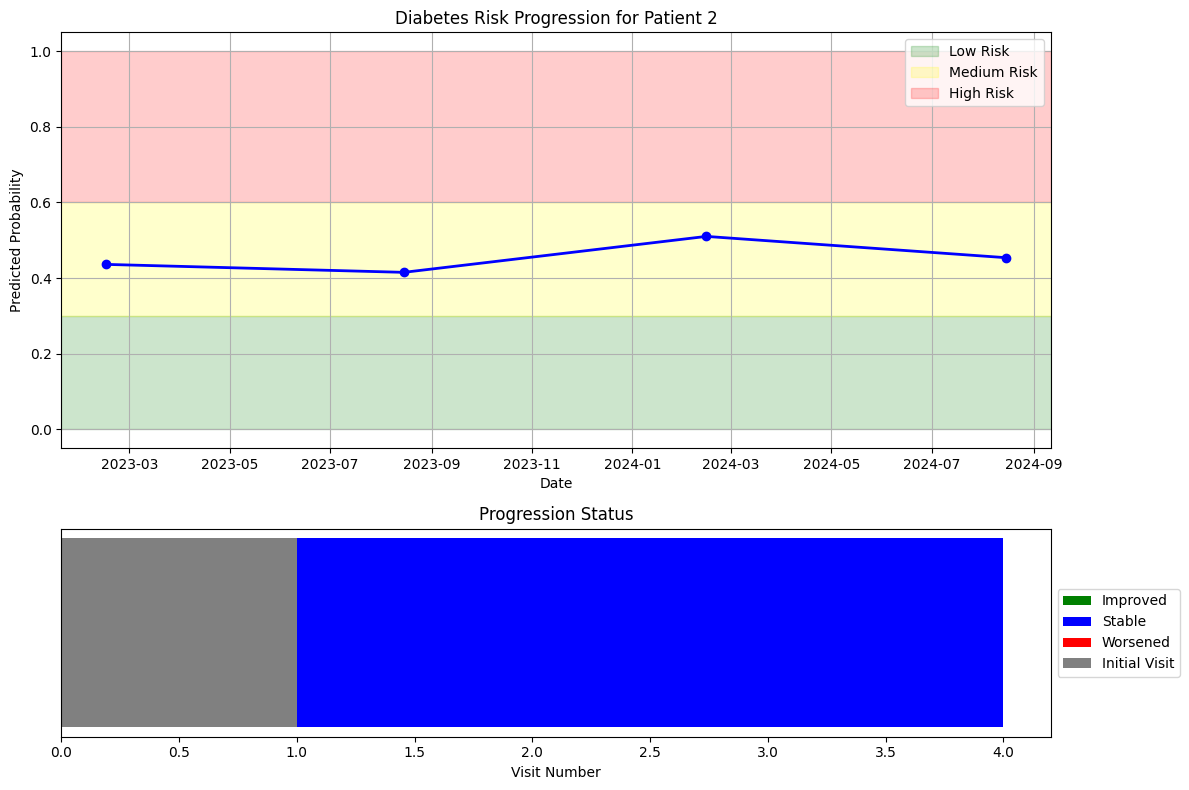

c:\Users\Hp\Desktop\workspace\projects\diabetes-predictor\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


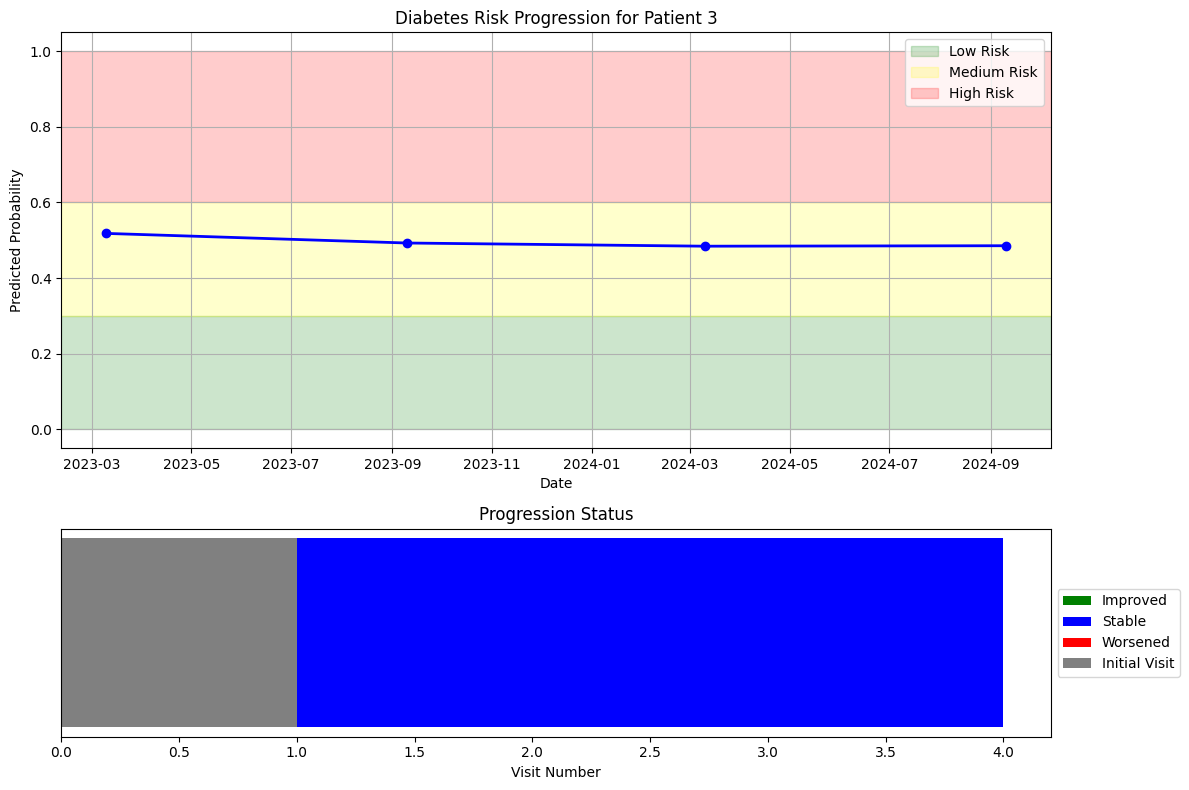

In [8]:
def visualize_progression(patient_id):
    """
    Create visualization of a patient's diabetes risk progression over time
    
    Parameters:
    patient_id (int or str): Patient ID to visualize
    """
    results = check_progression(patient_id)
    
    if results is None:
        return
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1])
    
    # Plot probability over time
    ax1.plot(results['Date'], results['Predicted_Probability'], 'b-o', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Predicted Probability')
    ax1.set_title(f'Diabetes Risk Progression for Patient {patient_id}')
    ax1.grid(True)
    
    # Add risk level zones
    ax1.axhspan(0, 0.3, alpha=0.2, color='green', label='Low Risk')
    ax1.axhspan(0.3, 0.6, alpha=0.2, color='yellow', label='Medium Risk')
    ax1.axhspan(0.6, 1.0, alpha=0.2, color='red', label='High Risk')
    ax1.legend()
    
    # Plot progression status
    colors = {'Improved': 'green', 'Stable': 'blue', 'Worsened': 'red', 'Initial Visit': 'gray'}
    for i, (prog, date) in enumerate(zip(results['Progression'], results['Date'])):
        ax2.barh(0, 1, left=i, color=colors[prog])
    
    ax2.set_yticks([])
    ax2.set_xlabel('Visit Number')
    ax2.set_title('Progression Status')
    
    # Add legend for progression
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=status) 
                      for status, color in colors.items()]
    ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

# Test the visualization with a few patients
for patient_id in unique_patients[:3]:
    visualize_progression(patient_id)
    print("\n" + "="*50 + "\n")